# Lecture 27 - How to Optimize Expensive Functions

## Objectives

+ Optimize an expensive black-box function under a limited budget.
+ Quantify the value of the information extracted from an experiment/simulation.

Let's load the usual suspects:

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import GPy
import numpy
import scipy.stats as stats
import numpy as np
from ipywidgets import interactive

We are going to addresss the problem:
$$
\mathbf{x}^* = \arg\max_{\mathbf{x}}f(\mathbf{x}).
$$
under the assumption that:
+ we can evaluate $f(\mathbf{x})$ at any $\mathbf{x}$;
+ evaluating $f(\mathbf{x})$ takes a lot of time/money;
+ we cannot evaluate the gradient $\nabla f(\mathbf{x})$;
+ the dimensionality of $\mathbf{x}$ is not very high.

### A stupid - 1D function to play with:
Here are hypothetical objective function to play with.

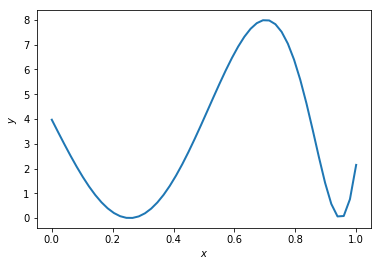

In [4]:
# Assumed to be 1D and defined in [0, 1]
def f(x):
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

x = np.linspace(0, 1)
plt.plot(x, f(x), linewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$')

Of course, this one takes not time and optimizing it is not a real challenge.
However, we need to finish this hands on today...

## Starting data
Let us generate some starting data:

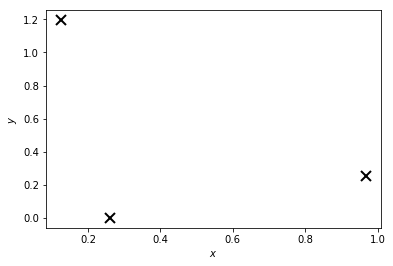

In [5]:
np.random.seed(123456) # For reproducibility
n_init = 3
X = np.random.rand(n_init)
Y = f(X)
plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$')

### The predictive distribution
Assume that we do some kind of Bayesian regression, using the data we have so far.
For example, we may do Gaussian process regression (GPR).
In general, at an arbitary new point $x$, we will have a *predictive distribution* over the
possible values $y$, $p(y|\mathbf{x})$.
The predictive distribution gives your beleifs about $y$ at $\mathbf{x}$.

Throughout this, we assume that we have a Gaussian approximation to that predictive distribution:
$$
p(y|\mathbf{x}) = \mathcal{N}\left(y|m(\mathbf{x}), \sigma^2(\mathbf{x})\right),
$$
where $m(\mathbf{x})$ and $\sigma^2(\mathbf{x})$ are the predictive mean and variance respectively.

Here is an example with GPR:

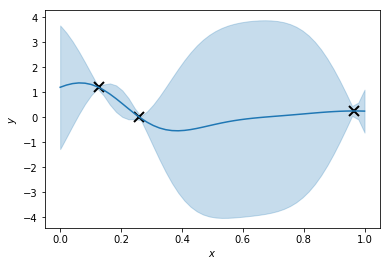

In [6]:
# The kernel we use
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
# Assuming that we know there is no measurement noise:
gpr.likelihood.variance.constrain_fixed(1e-16)
# You can evaluate the predictive distribution anywhere:
m, sigma2 = gpr.predict(x[:, None])
# And you can visualize the results as follows
# Standard deviation
sigma = np.sqrt(sigma2)
# Lower quantile
l = m - 1.96 * sigma
u = m + 1.96 * sigma
fig, ax = plt.subplots()
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x, m)
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)

### Maximum upper interval

In [7]:
def mui(m, sigma, ymax, psi=1.96):
    return m + psi * sigma

Let's visualize this:

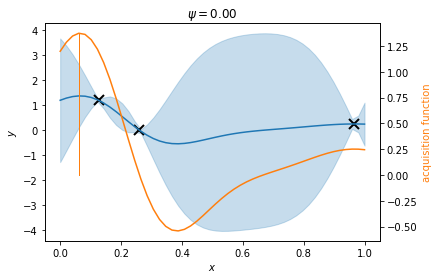

In [12]:
def plot_mui(psi=0.):
    fig, ax = plt.subplots()
    ax.set_title('$\psi={0:1.2f}$'.format(psi))
    ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.plot(x, m)
    ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
    af_values = mui(m, sigma, Y.max(), psi)
    next_id = np.argmax(af_values)
    next_x = x[next_id]
    af_max = af_values[next_id]
    ax2 = ax.twinx()
    ax2.plot(x, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)

interactive(plot_mui, psi=(0., 4., 0.001))

#### Questions
+ Experiment with different values of $\psi$.
+ When do you get exploration?
+ When do you get exploitation?

### Probability of improvement

In [13]:
def poi(m, sigma, ymax, psi=0.):
    """
    Return the probability of improvement.
    
    Arguments:
    m        -      the predictive mean at the test points.
    sigma        -  the predictive standard deviation at the test points.
    ymax     -      the maximum observed value (so far).
    psi      -      a parameter that controls exploration.
    """
    return 1. - scipy.stats.norm.cdf((ymax + psi - m) / sigma)

Let's visualize this:

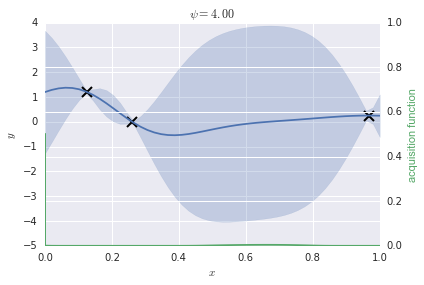

In [220]:
def plot_poi(psi=0.):
    fig, ax = plt.subplots()
    ax.set_title('$\psi={0:1.2f}$'.format(psi))
    ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.plot(x, m)
    ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
    af_values = poi(m, sigma, Y.max(), psi)
    ax2 = ax.twinx()
    ax2.plot(x, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)
    ax2.set_ylim(0, 1)

interactive(plot_poi, psi=(0., 4., 0.001))

#### Questions
+ Experiment with different values of $\psi$.
+ When do you get exploration?
+ When do you get exploitation?

### Expected improvement

(0, 1)

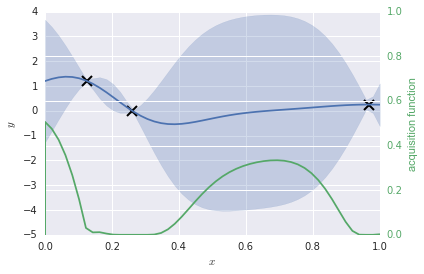

In [233]:
def ei(m, sigma, ymax, psi=0.):
    u = (m - ymax) / sigma
    ei = sigma * (u * stats.norm.cdf(u) + stats.norm.pdf(u))
    ei[sigma <= 0.] = 0.
    return ei

af_values = ei(m, sigma, Y.max())
idx = np.argmax(af_values)
af_max = af_values[idx]
next_x = x[idx]

fig, ax = plt.subplots()
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.plot(x, m)
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
ax2 = ax.twinx()
ax2.plot(x, af_values, color=sns.color_palette()[1])
plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)
ax2.set_ylim(0, 1)

### The main algorithm

Here is an implementation of the main algorithm that is independent of the acquisition function.

In [246]:
def maximize(f, gpr, X_design, alpha=ei, psi=0., max_it=6):
    """
    Optimize f using a limited number of evaluations.
    """
    af_all = []
    for count in xrange(max_it):
        m, sigma2 = gpr.predict(X_design)
        sigma = np.sqrt(sigma2)
        l = m - 1.96 * sigma
        u = m + 1.96 * sigma
        af_values = alpha(m, sigma, gpr.Y.max(), psi=psi)
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        gpr.set_XY(X, y)
        # Uncomment the following to optimize the hyper-parameters
        # gpr.optimize()
        af_all.append(af_values[i])
        fig, ax = plt.subplots()
        ax.plot(gpr.X, gpr.Y, 'kx', markersize=10, markeredgewidth=2)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.plot(x, m)
        ax.fill_between(X_design.flatten(), l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
        ax2 = ax.twinx()
        ax2.plot(X_design, af_values, color=sns.color_palette()[1])
        plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
        ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
        ax2.plot(X_design[i, :] * np.ones(100), np.linspace(0, af_values[i], 100), color=sns.color_palette()[1],
                 linewidth=1)
    return af_all

[array([ 0.5062436]),
 array([ 0.0198551]),
 array([ 0.12558069]),
 array([ 0.22828814]),
 array([ 0.09740942]),
 array([ 0.00045314]),
 array([  3.70297054e-05]),
 array([ nan]),
 array([ nan]),
 array([ nan])]

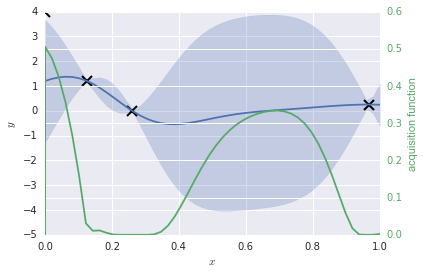

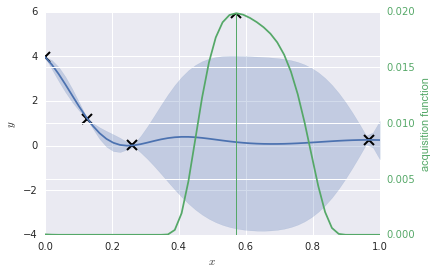

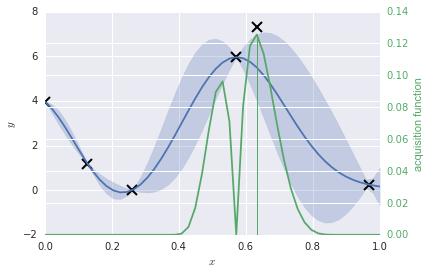

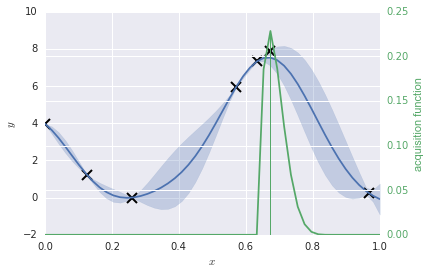

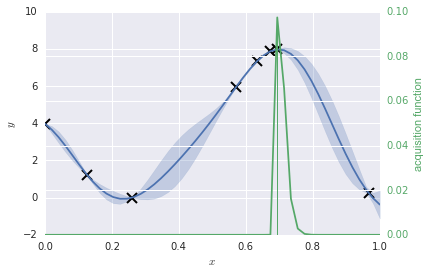

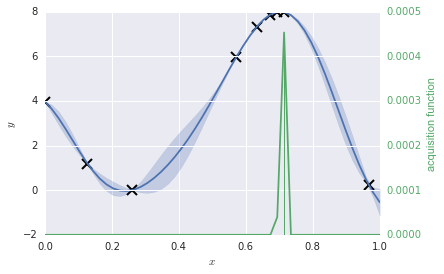

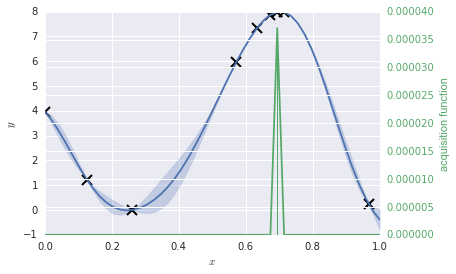

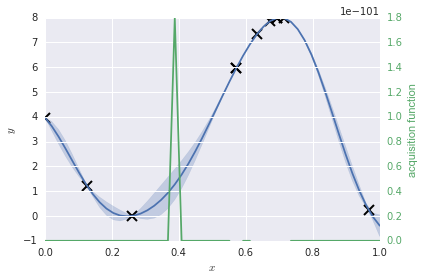

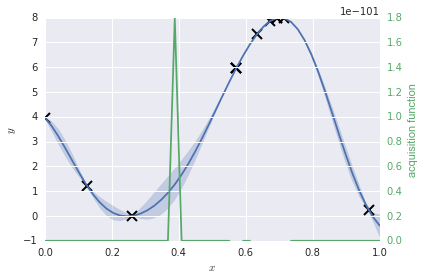

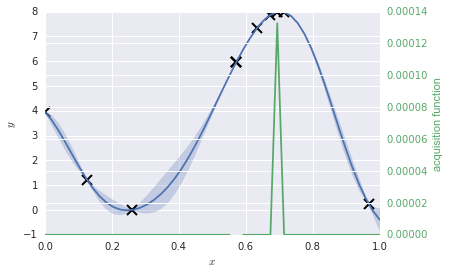

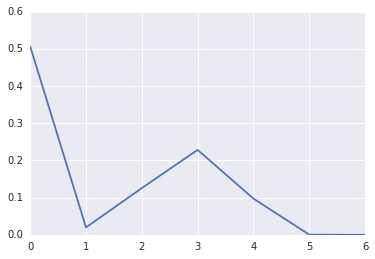

In [254]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

# Run the algorithm
af_all = maximize(f, gpr, x[:, None], alpha=ei, psi=0., max_it=10)

# Plot
fig, ax = plt.subplots()
ax.plot(af_all)
af_all

#### Questions
+ Rerun the main algorithm for EI by optimizing the hyper-parameters.
+ Repeat the main algorithm using POI for a $\psi$ that exploits. Does the method converge?
+ Repeat the main algorithm using POI for a $\psi$ that explores. Does the method converge?
+ Repeat the main algorithm using MUI for a $\psi$ that exploits. Does the method converge?
+ Repeat the main algorithm using MUI for a $\psi$ that explores. Does the method converge?
+ Go to the [GPyOpt tutorial](http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/GPyOpt_reference_manual.ipynb). Use it to solve our problem using EI and plot the convergence diagnostics. Then do their 2D problem.